In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import helpers

from PIL import Image, ImageFile
from timeit import default_timer as timer
from pathlib import Path
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
from model_mobile_vig import mobilevig_ti
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from helpers import plot_loss_curves


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# train_dir = Path("./data/data-calvin/train/")
# test_dir = Path("./data/data-calvin/test/")
origin_dir = Path("./data/data-buah/data")

torch.cuda.empty_cache()

# train_preprocess = v2.Compose(
#     [
#         v2.ToImage(),
#         v2.Resize((224, 224)),
#         v2.RandomErasing(p=0.25),
#         v2.RandAugment(),
#         v2.ToDtype(torch.float32, scale=True),
#         v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ]
# )

test_preprpocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

origin_set = datasets.ImageFolder(str(origin_dir), transform=test_preprpocess)
# train_dataset = datasets.ImageFolder(str(train_dir), transform=train_preprocess)
# test_dataset = datasets.ImageFolder(str(test_dir), transform=test_preprpocess)
n = len(origin_set)  # total number of examples
n_test = int(0.2 * n)
test_dataset = torch.utils.data.Subset(origin_set, range(n_test))
train_dataset = torch.utils.data.Subset(origin_set, range(n_test, n))
class_names = origin_set.classes

print(f"Total train image: {len(train_dataset)}")
print(f"Total test image: {len(test_dataset)}")
print(f"Classes/label: {class_names}")

NUM_WORKERS = 4
BATCH_SIZE = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
model = mobilevig_ti(num_classes=len(class_names)).to(device)

LEARNING_RATE = 0.002
NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps,
)


cuda
Total train image: 10890
Total test image: 2722
Classes/label: ['Apple_Bad', 'Apple_Good', 'Banana_Bad', 'Banana_Good', 'Guava_Bad', 'Guava_Good', 'Lime_Bad', 'Lime_Good', 'Orange_Bad', 'Orange_Good', 'Pomegranate_Bad', 'Pomegranate_Good']


In [2]:
import torch.utils.data


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        lr_scheduler.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if progress_bar:
            progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [3]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            if progress_bar:
                progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [4]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    use_progress_bar: bool = False,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    if use_progress_bar:
        progress_bar = tqdm(
            total=len(train_dataloader) + len(test_dataloader), desc="Processing Batch"
        )

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), desc="Processing Epoch"):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )

        print(
            f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}% | LR: {lr_scheduler.get_last_lr()}"
        )
        progress_bar.reset()
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [5]:
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Start the timer
start_time = timer()

# Setup training and save the results
results = train(
    model=model.to(device),
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=torch.device(device),
    use_progress_bar=True,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


cuda


Processing Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Processing Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.01307 | Test loss: 3.50898 | Train acc: 83.67% | Test acc: 11.48% | LR: [0.0019876883405951376]
Epoch: 2 | Train loss: 0.78232 | Test loss: 3.43196 | Train acc: 91.66% | Test acc: 15.48% | LR: [0.0019510565162951564]
Epoch: 3 | Train loss: 0.67212 | Test loss: 3.71652 | Train acc: 96.15% | Test acc: 14.35% | LR: [0.0018910065241883693]
Epoch: 4 | Train loss: 0.62204 | Test loss: 3.42813 | Train acc: 97.78% | Test acc: 15.13% | LR: [0.001809016994374949]
Epoch: 5 | Train loss: 0.59536 | Test loss: 3.40075 | Train acc: 98.66% | Test acc: 15.52% | LR: [0.0017071067811865492]
Epoch: 6 | Train loss: 0.58807 | Test loss: 3.53222 | Train acc: 98.70% | Test acc: 15.31% | LR: [0.0015877852522924742]
Epoch: 7 | Train loss: 0.60117 | Test loss: 3.70740 | Train acc: 98.47% | Test acc: 15.66% | LR: [0.0014539904997395486]
Epoch: 8 | Train loss: 0.56469 | Test loss: 3.35948 | Train acc: 99.40% | Test acc: 15.48% | LR: [0.0013090169943749497]
Epoch: 9 | Train loss: 0.57375 | 

In [6]:
import pickle
import json

with open("./results/data_calvin_mobile_vig_2_results.pkl", "wb") as f:
    pickle.dump(results, f)


with open("./results/data_calvin_mobile_vig_2_results.pkl", "rb") as f:
    loaded_dict = pickle.load(f)

print(json.dumps(results, indent=4))


{
    "train_loss": [
        1.0130673480588337,
        0.7823232745015344,
        0.6721201566762702,
        0.6220413578111071,
        0.5953589462956717,
        0.5880658065163812,
        0.6011682464632877,
        0.564688042845837,
        0.5737486370774203,
        0.5724431733752406,
        0.5614917811959289,
        0.544585354799448,
        0.5435539040454599,
        0.5417893764584564,
        0.5396390467189079,
        0.5420901671398518,
        0.5384254476358724,
        0.5365584825360498,
        0.535594568696133,
        0.5350540238757466
    ],
    "train_acc": [
        0.8367187500000001,
        0.916624273255814,
        0.9614825581395349,
        0.9778343023255814,
        0.9865552325581395,
        0.9870276162790699,
        0.9847383720930233,
        0.9940225290697675,
        0.9900436046511628,
        0.992841569767442,
        0.9933684593023255,
        0.9988190406976745,
        0.9980922965116279,
        0.998546511627907,
       

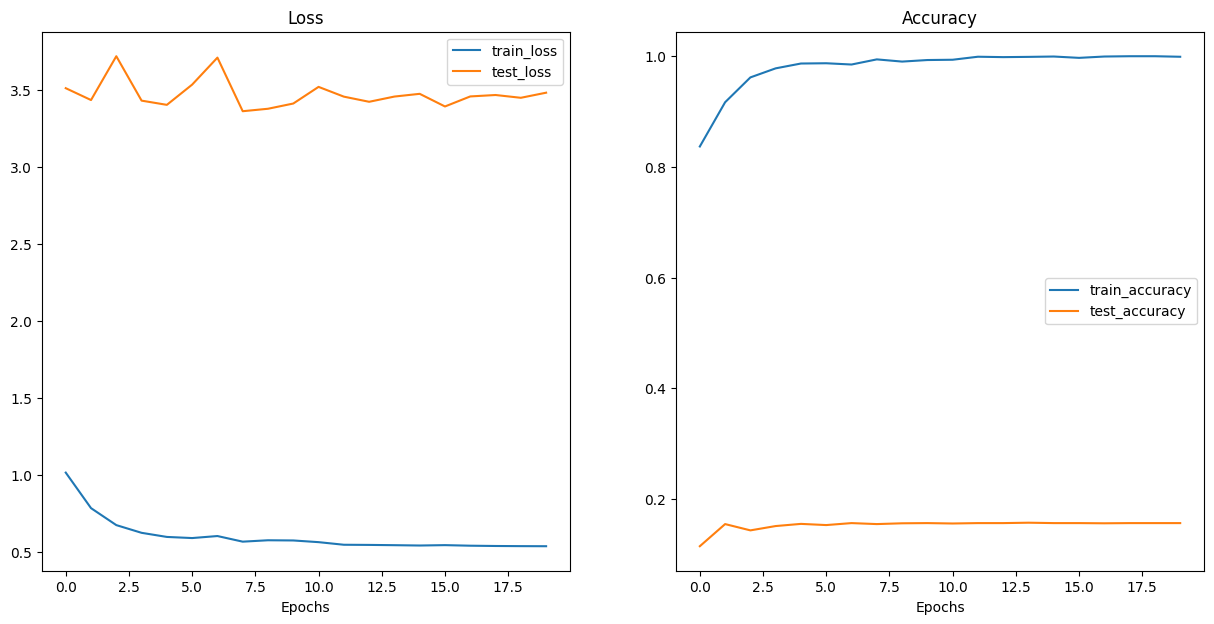

In [7]:
# Plot the loss curves of our model
plot_loss_curves(results)


In [8]:
save_dir = Path("./models/data_calvin_mobile_vig_2.pth")

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    save_dir,
)


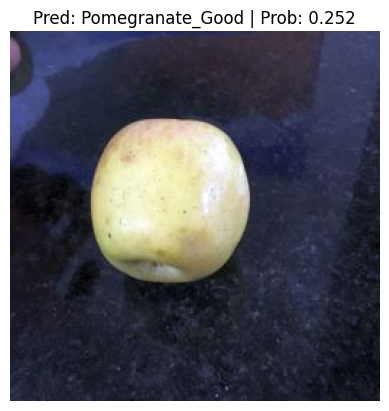

In [9]:
# Setup path to data folder
custom_image_path = Path("./data/data-calvin/test/Apple_Good/IMG_9371.JPG")

# Predict on custom image
helpers.pred_and_plot_image(
    model=model, image_path=str(custom_image_path), class_names=class_names
)
